# Fitting of k2-186 b

In [122]:
from astropy.io import fits
from astropy.stats import sigma_clip
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import medfilt
%matplotlib inline  


In [123]:
#load EXO file and k2sc file
hdu_list = fits.open('/home/tunde/Dropbox/Ph.D/report/year2/hlsp_k2sc_k2_llc_211906650-c05_kepler_v2_lc.fits')
data=np.loadtxt("/home/tunde/Dropbox/Ph.D/report/year2/k2_186.txt")

q=hdu_list[1].data["quality"]
time, flux, err = hdu_list[1].data["time"][q==0], hdu_list[1].data["flux"][q==0], hdu_list[1].data["error"][q==0]

ind=np.argwhere(np.isfinite(flux))
time, flux, err= time[ind][:,0], flux[ind][:,0], err[ind][:,0]

#remove trend using a running median of 51 points
medfilt=medfilt(flux,kernel_size=51)
flux=flux/medfilt



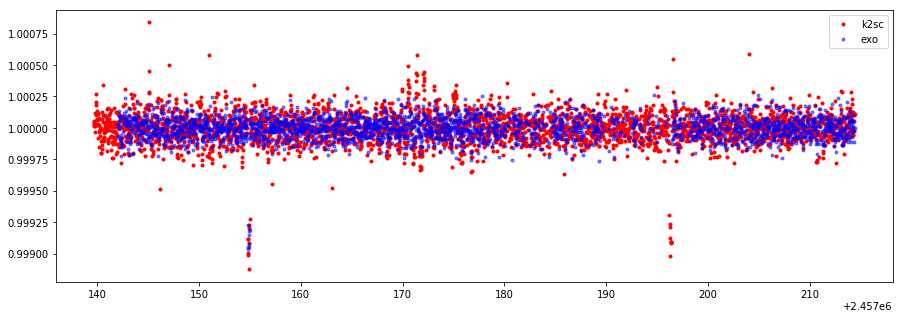

In [124]:
plt.figure(figsize=(15,5))
plt.plot(time+2454833,flux,"r.",label="k2sc")
plt.plot(data[:,0]+2400000.0,data[:,1],"b.",label="exo",alpha=0.5)
plt.legend()



Text(0.5, 1.0, 'P = 2363.31 - 2321.85 = 41.46 days')

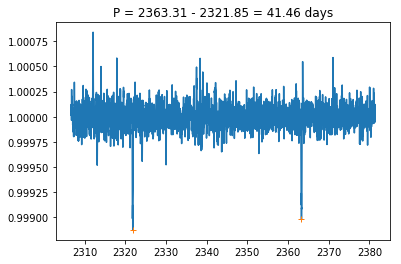

In [125]:
#roughlt estimate time beween transits(peaks)
from scipy.signal import find_peaks as fp

pks,_=fp(-flux,distance= 1000)
plt.plot(time,flux)
plt.plot(time[pks],flux[pks],"+")

plt.title("P = %.2f - %.2f = %.2f days"%(time[pks][1],time[pks][0],time[pks][1]-time[pks][0]))

## Search for the transits and obtain the period using BLS

In [126]:
from astropy.stats import BoxLeastSquares

bls_model = BoxLeastSquares(time,flux)

period_grid = np.linspace(35, 50, 10000) # period grid to search
duration = 0.15   #duration to search

bls=bls_model.power(period_grid,  duration, oversample=20)

#find period with the maximum power
index = np.argmax(bls.power)
bls_power_max = bls.power[index]
bls_period = bls.period[index]
bls_t0 = bls.transit_time[index]
bls_depth = bls.depth[index]

Text(0, 0.5, 'Power')

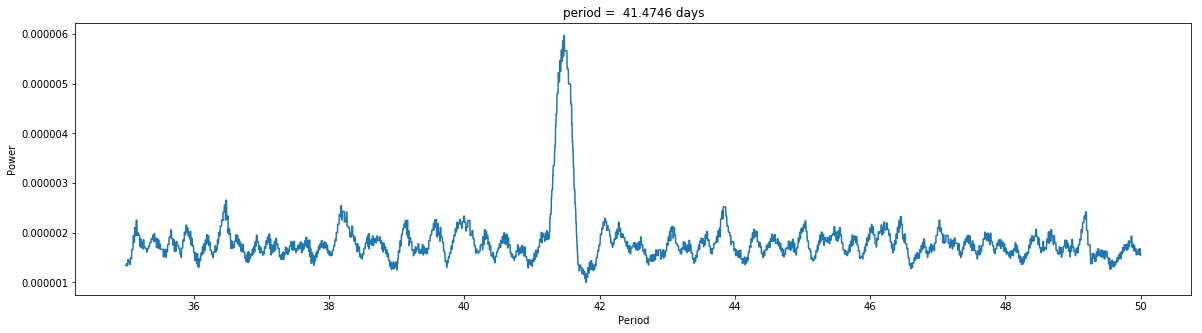

In [127]:
plt.figure(figsize=(20,5))
plt.plot(bls.period, bls.power)
plt.title("period =  {0:.4f} days".format(bls_period))
plt.xlabel("Period")
plt.ylabel("Power")


(-1, 1)

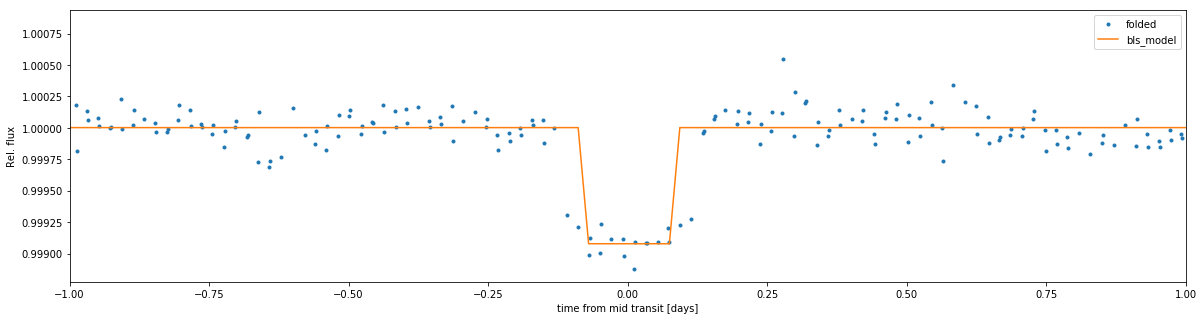

In [128]:
#show the BLS model on the data folded to the obtained BLS period
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
plt.figure(figsize=(20,5))
plt.plot(x_fold, flux, ".",label="folded")
#
inds = np.argsort(x_fold)
plt.plot(x_fold[inds], bls_model.model(time, bls_period, duration, bls_t0)[inds],label="bls_model")
plt.legend()
plt.ylabel("Rel. flux")
plt.xlabel("time from mid transit [days]")
plt.xlim(-1,1)

In [135]:
import batman

def model(params,t, data=None):
    btpar = batman.TransitParams()      #object to store transit parameters
    btpar.t0 = params[0]                #time of inferior conjunction
    btpar.per = params [1]                      #orbital period
    btpar.rp = params[2]                #planet radius (in units of stellar radii)
    btpar.inc = params[3]               #orbital inclination (in degrees)
    btpar.a = params[4]                #semi-major axis (in units of stellar radii)
    btpar.ecc = 0                     #eccentricity
    btpar.w = 90                      #longitude of periastron (in degrees)
    btpar.limb_dark = "quadratic"       #limb darkening model
    btpar.u = [params[5], params[6]]               #limb darkening coefficients
    m = batman.TransitModel(btpar, t,supersample_factor=5, exp_time = 4.431539800545257e-05)    #initializes model
    
    if data is None:
        return m.light_curve(btpar)
    return data - m.light_curve(btpar) 


In [136]:
from scipy.optimize import least_squares as ls

p0=[2321.85,41.4746,0.02,89.5,48,0.2,0.3]
result=ls(model,p0,args=(time,flux),bounds=([2320,41,0.01,89,45,0.15,0.15],[2322,43,0.05,90,52,0.45,0.45]))



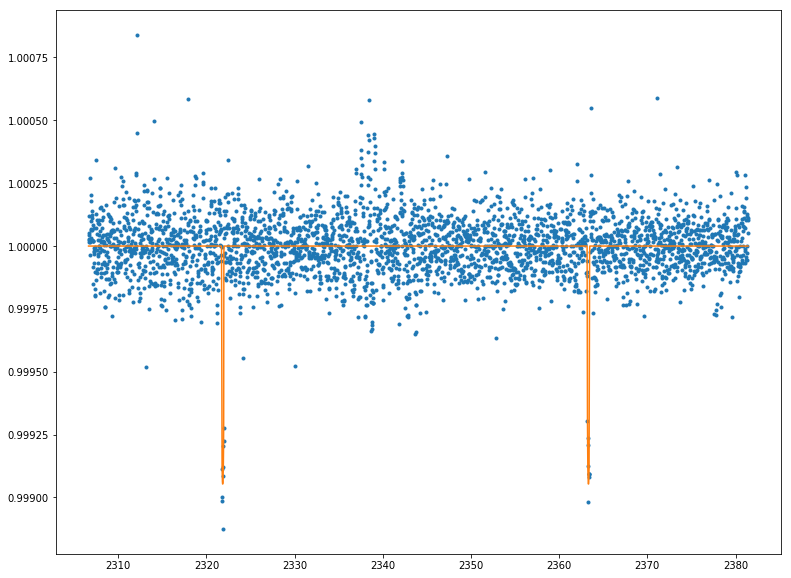

In [137]:
plt.figure(figsize=(13,10))
plt.plot(time,flux,".")
plt.plot(time, model(result.x,time))


In [132]:
result.x

array([2.32187042e+03, 4.14746003e+01, 1.61138401e-02, 8.93314096e+01,
       5.00404690e+01, 4.48671177e-01, 2.14587211e-01])

## Run MCMC

In [107]:
ind=np.argsort(x_fold)
x_fold, flux, err = x_fold[ind], flux[ind], err[ind]
ind2=np.abs(x_fold) < 1 
x_fold, flux = x_fold[ind2], flux[ind2]


In [12]:

def lnprior(params):
    rp,inc,a= params   #ln_j is jitter to account for incorrectness of quoted errors
    if 1 < t0 < 1 and 0.01 < rp < 0.1 and 88 < inc < 90 and 40 < a < 60:
        return 0.0
    return -np.inf 

       
def lnlike(params, t, y, yerr):
    t0,rp,inc,a= params
#    inv_sigma2 = 1.0/(yerr**2 + model(params, t) **2*np.exp(2*ln_j))
    return -0.5 * np.sum(((y - model(params, t))/yerr) ** 2)#-0.5*(np.sum((y-model(params, t))**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(params, t, y, yerr):
    lp = lnprior(params)
    return lp + lnlike(params, t, y, yerr) if np.isfinite(lp) else -np.inf


In [13]:
#DETECTS WHERE THE PHASE SHOULD BEGIN AND END
n_phase_min, n_phase_max = int(np.min(time * bls_period)),  int(np.max(time * bls_period))
#ADDS A LIST OF NUMBERST TO COMPUTE THE PHASE TO. THIS WILL BE SENT TO PLOTTER
# print n_phase_min, n_phase_max
list_of_phases = np.arange(n_phase_min, n_phase_max+1+1)



output_original_phase =[]
for number in list_of_phases:
    plt.plot(number*bls_period + phase_fit*bls_period, fit_model, 'k')
    #output_original_phase.append(zip(number*1./best_freq+phase_fit*1./best_freq, y_fit-np.median(fixed_data)))

NameError: name 'phase_fit' is not defined

In [ ]:
n_phase_min, n_phase_max = int(np.min(x_fold * bls_period)),  int(np.max(x_fold * bls_period))


In [ ]:
(max(time)-min(time))/bls_period

In [ ]:
max(x_fold)-min(x_fold)